This notebook was used to generate the example explaining the ground truth generation

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/MyDrive/TFE_crowd_counting/CSRNet-pytorch')

import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
from scipy import spatial
from matplotlib import cm as CM
from image import *
                          
%matplotlib inline

Mounted at /content/gdrive


In [ ]:
root = '/content/gdrive/My Drive/TFE_crowd_counting/Dataset/'
images_path = os.path.join(root,'Basic datas/images/Example_groundTruth')
GT_path = os.path.join(root,'Basic datas/ground_truth/Example_groundTruth')
path_sets = [images_path] #All images at the same place
img_format = '.png' #or '.png' or '.jpg'

img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [ ]:
#this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet

#This function create the density by using adaptive kernels
def gaussian_filter_density(gt):
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density
    pts = list(zip(np.nonzero(gt)[1],np.nonzero(gt)[0]))  
    pts = np.array(pts) #coordinates of the heads (23 for this image)
    # print(pts)
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)
    
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
        if((pt[0] == 446 and pt[1] == 358) or (pt[0] == 303 and pt[1] == 401)):
          print(pt)
          print(sigma)
    return density

In [ ]:
#Method to generate h5 ground_truth file based on the paths to the images file
#Crowded = False -> Usage of only gaussian // Crowded = True -> Usage of geometric adaptive kernel

def gt_gen(img_paths, crowded = True ,Verbose = False):
  count=1
  for img_path in img_paths:
      mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
      img= plt.imread(img_path)
      k = np.zeros((img.shape[0],img.shape[1]))
      gt = mat["image_info"][0,0][0,0][0]
      for i in range(0,len(gt)):
          if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
              k[int(gt[i][1]),int(gt[i][0])]=1.

      #HERE : k has a size of 768, 1024 (resolution of the image) => BEFORE convolution
      
      print("BEFORE CONVOLUTION")
      # print("For point [358][446]")
      print("For head 1") #the guy who is standing up
      print(k[356][444:449])
      print(k[357][444:449])
      print(k[358][444:449])
      print(k[359][444:449])
      print(k[360][444:449])
      
      # print("For point [401][303]")
      print("For head 2") #the guy with a checkered shirt
      print(k[399][301:306])
      print(k[400][301:306])
      print(k[401][301:306])
      print(k[402][301:306])
      print(k[403][301:306])

      initialK = k #without convolutions
      # plt.imshow(k,cmap=CM.jet)
      #density generation for crowded image
      if crowded:
        k = gaussian_filter_density(k)
      #density generation for non crowded image
      else:
        k = gaussian_filter(k,15)
      print("K2 :", k.sum())

      print("AFTER CONVOLUTION")
      # print("For point [358][446]") #the guy who is standing up
      print("For head 1") #the guy who is standing up
      print(k[356][444:449])
      print(k[357][444:449])
      print(k[358][444:449])
      print(k[359][444:449])
      print(k[360][444:449])
      
      # print("For point [401][303]") #the guy with a checkered shirt
      print("For head 2") #the guy with a checkered shirt
      print(k[399][301:306])
      print(k[400][301:306])
      print(k[401][301:306])
      print(k[402][301:306])
      print(k[403][301:306])
      
      # plt.imshow(k,cmap=CM.jet)
      #HERE : k has a size of 768, 1024 (resolution of the image) => AFTER convolution

      with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
              hf['density'] = k
      if Verbose:
        print("image "+str(count) + "/" + str(len(img_paths))+ " done")
        count+=1
      return initialK, k

In [ ]:
initialK, finalK = gt_gen(img_paths,Verbose = True)

BEFORE CONVOLUTION
For head 1
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
For head 2
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[[  0.          20.61552813  30.52867504  70.9365914 ]
 [  0.          57.31491952  72.09022125  77.12976079]
 [  0.          24.69817807  69.35416354  79.15806971]
 [  0.          20.61552813  21.37755833  88.52683209]
 [  0.          24.69817807  44.72135955  70.9365914 ]
 [  0.          21.37755833  30.52867504  73.78346698]
 [  0.          50.15974482  76.92203845  77.38862966]
 [  0.          28.01785145  29.06888371  50.15974482]
 [  0.          22.84731932  28.01785145  39.35733731]
 [  0.          21.63330765  24.69817807  41.14608122]
 [  0.          30.01666204  39.35733731  44.10215414]
 [  0.          44.72135955  69.35416354  73.78346698]
 [  0.          22.84731932  29.06888371  37.01351105]
 [  0.          14.2126704   20.24845673  24.69817807]
 [  0.          41.

/content/gdrive/My Drive/TFE_crowd_counting/Dataset/Basic datas/images/Example_groundTruth/IMG_6.jpg


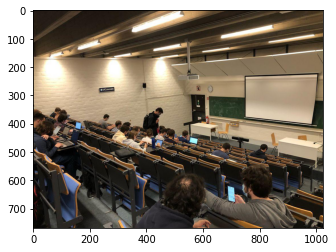

In [ ]:
plt.imshow(Image.open(img_paths[0]))
print(img_paths[0])

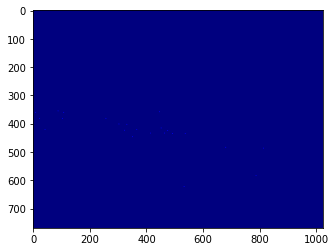

In [ ]:
plt.imshow(initialK,cmap=CM.jet)

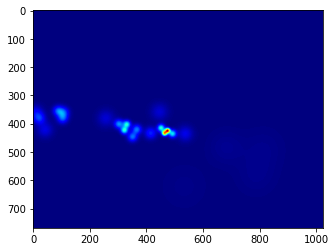

In [ ]:
plt.imshow(finalK,cmap=CM.jet)

In [ ]:
print(np.sum(groundtruth))

22.636549
